In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

['sample_submission.csv', 'plates.zip']
After zip extraction:
['plates', '__notebook_source__.ipynb', '__MACOSX']


In [2]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['train', 'test', '.DS_Store']


In [3]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 4016.98it/s]


In [4]:
!ls train

cleaned  dirty


In [5]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms1 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_transforms2 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_transforms3 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomGrayscale(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_transforms4 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_transforms5 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_transforms6 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomGrayscale(),
    transforms.ColorJitter(),
    transforms.RandomRotation(degrees=90),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_transforms7 = transforms.Compose([
    transforms.CenterCrop(20),
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset1 = torchvision.datasets.ImageFolder(train_dir, train_transforms1)
train_dataset2 = torchvision.datasets.ImageFolder(train_dir, train_transforms2)
train_dataset3 = torchvision.datasets.ImageFolder(train_dir, train_transforms3)
train_dataset4 = torchvision.datasets.ImageFolder(train_dir, train_transforms4)
train_dataset5 = torchvision.datasets.ImageFolder(train_dir, train_transforms5)
train_dataset6 = torchvision.datasets.ImageFolder(train_dir, train_transforms6)
train_dataset7 = torchvision.datasets.ImageFolder(train_dir, train_transforms7)

train_dataset = torch.utils.data.ConcatDataset([train_dataset1, train_dataset2, train_dataset3, train_dataset4, train_dataset5, train_dataset6, train_dataset7])
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size
)

In [6]:
len(train_dataloader), len(train_dataset)

(28, 224)

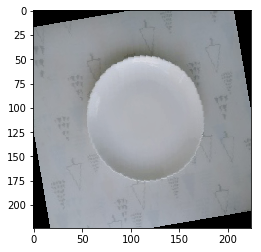

In [7]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

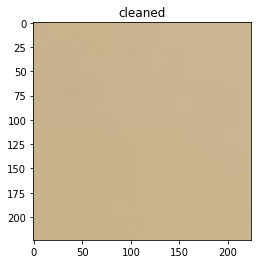

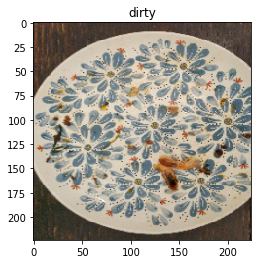

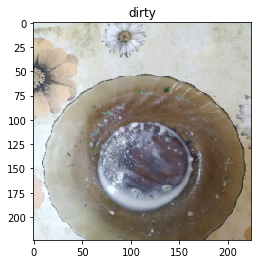

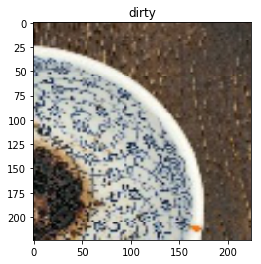

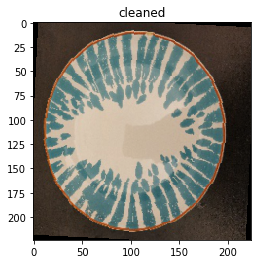

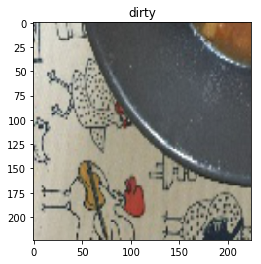

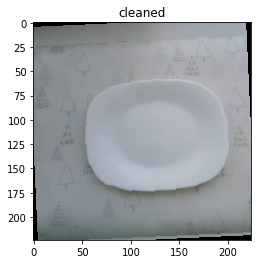

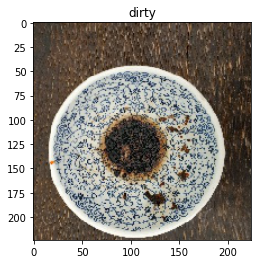

In [8]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [9]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [10]:
import torch.nn as nn
import torch.nn.functional as F
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

In [11]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

#for param in model.maxpool.parameters():
#    param.requires_grad = True    
    
for param in model.avgpool.parameters():
    param.requires_grad = True 

for param in model.layer4.parameters():
    param.requires_grad = True

model.fc = torch.nn.Sequential(
            torch.nn.Linear(model.fc.in_features, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 2))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr = 0.001)

# Decay LR by a factor of 0.5 every 1 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 46555091.45it/s]


In [12]:
train_model(model, loss, optimizer, scheduler, num_epochs=10);

Epoch 0/9:


100%|██████████| 28/28 [00:01<00:00, 14.34it/s]

train Loss: 0.0326 Acc: 0.7545



100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

val Loss: 0.0455 Acc: 0.7500
Epoch 1/9:



100%|██████████| 28/28 [00:01<00:00, 19.99it/s]

train Loss: 0.0172 Acc: 0.8973



100%|██████████| 1/1 [00:00<00:00,  5.22it/s]

val Loss: 0.0242 Acc: 0.8750
Epoch 2/9:



100%|██████████| 28/28 [00:01<00:00, 19.80it/s]

train Loss: 0.0142 Acc: 0.9063



100%|██████████| 1/1 [00:00<00:00,  5.18it/s]

val Loss: 0.0186 Acc: 0.8750
Epoch 3/9:



100%|██████████| 28/28 [00:01<00:00, 20.15it/s]

train Loss: 0.0098 Acc: 0.9464



100%|██████████| 1/1 [00:00<00:00,  5.10it/s]

val Loss: 0.0167 Acc: 0.7500
Epoch 4/9:



100%|██████████| 28/28 [00:01<00:00, 17.86it/s]

train Loss: 0.0106 Acc: 0.9464



100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

val Loss: 0.0230 Acc: 0.8750
Epoch 5/9:



100%|██████████| 28/28 [00:01<00:00, 16.50it/s]

train Loss: 0.0070 Acc: 0.9643



100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

val Loss: 0.0241 Acc: 0.8750
Epoch 6/9:



100%|██████████| 28/28 [00:01<00:00, 18.59it/s]

train Loss: 0.0069 Acc: 0.9554



100%|██████████| 1/1 [00:00<00:00,  5.03it/s]

val Loss: 0.0226 Acc: 0.8750
Epoch 7/9:



100%|██████████| 28/28 [00:01<00:00, 19.69it/s]

train Loss: 0.0096 Acc: 0.9330



100%|██████████| 1/1 [00:00<00:00,  5.14it/s]

val Loss: 0.0261 Acc: 0.7500
Epoch 8/9:



100%|██████████| 28/28 [00:01<00:00, 19.95it/s]

train Loss: 0.0072 Acc: 0.9643



100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

val Loss: 0.0290 Acc: 0.8750
Epoch 9/9:



100%|██████████| 28/28 [00:01<00:00, 15.61it/s]

train Loss: 0.0088 Acc: 0.9554



100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

val Loss: 0.0208 Acc: 0.8750


In [13]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [14]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [15]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test

In [16]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:03<00:00, 25.71it/s]


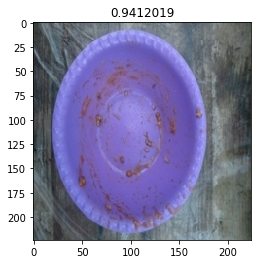

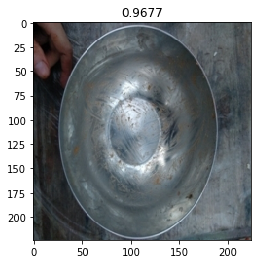

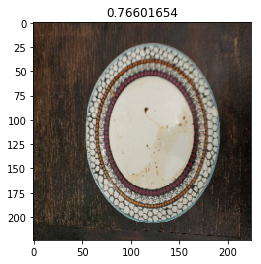

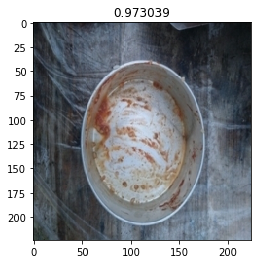

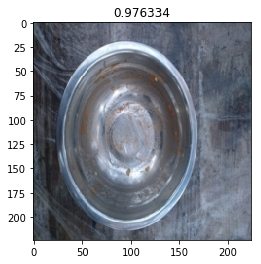

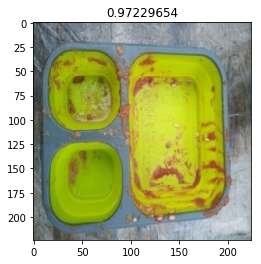

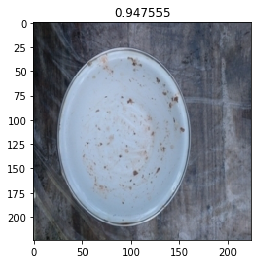

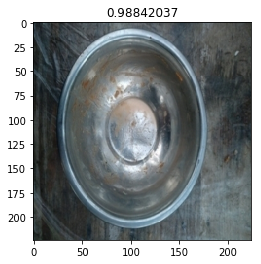

In [17]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [18]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [19]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty


In [20]:
submission_df.to_csv('submission.csv')

In [21]:
!rm -rf train val test